In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [3]:
4126610/Lv

1.649984006397441

In [4]:
400/Lv

0.0001599360255897641

In [3]:
#WATER

def manabe_rh(rhs, p):
#    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    rh = rhs*(p/p[0]-0.02)/(1-0.02)
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p,itop):
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

def column_water_mass(vmr,ph): #kg m-2
    mmr = vmr_to_mmr(vmr) #kg kg-1
    dp = np.diff(ph)
    M_water = np.sum(-dp*mmr/g)
    
    return M_water
    
def opt_column_water_to_rh(M_water,T_atm,p,ph,itop):
    
    def fun(rhs):
        rh = manabe_rh(rhs, p)
        vmr = rh_to_vmr(rh,T_atm,p,itop)
        rh_w_mass = column_water_mass(vmr,ph)
        res = rh_w_mass - M_water
        return res
    
    rhs_opt = optimize.brentq(fun, 0.3, 1)
    rh_opt = manabe_rh(rhs_opt, p)
    return rh_opt

In [5]:
#AIR

def convective_top(T_con,T_rad):
    itop = np.where(T_radiation - atmosphere['T'][0] == 0)[0][0]
    
    return itop

def coldpoint(T):
    itop = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
    
    return itop

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [6]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad): #find T after convective adjustment conserving thermal energy
    thermal_energy = TE(T_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [11]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

39
first with LH, then with heat sink:
surface T [287.9773717] 287.5834479460028
toa radiation [64.8015831] [63.75817705]
surface radiation 169.03854092711265 168.82684977141065
atmosphere radiative cooling [-104.23695783]
latent heat 0.0
sensible heat [104.17190353]
daily evaporation 0.0
daily rain [-3.60098887]


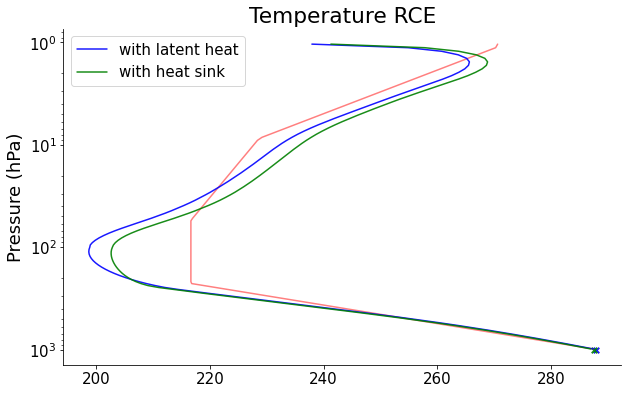

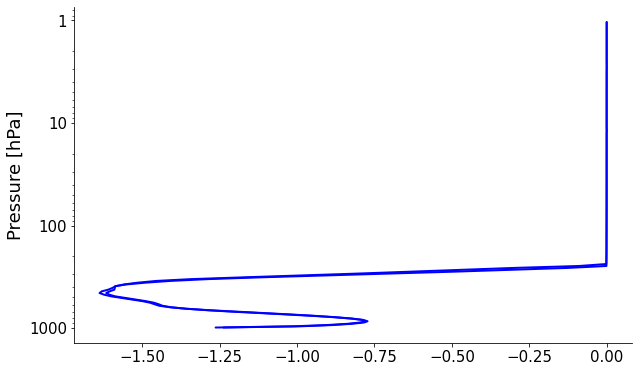

In [7]:
##TEST COLDPOINT to CONVECTIVE TOP

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

conv_top = np.where(np.diff(atmosphere['T'][0])>=0)[0][0]
conv_top = 25

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)



fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(atmosphere['T'][0])
    rad_heat_atm[:] = np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    heating_rates = rad_heat_atm/cp_air * g/np.diff(atmosphere['phlev']) * seconds_day
    
    

    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
#    LH = latent_heat(vmr_bl, surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 66
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += heating_rates * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    conv_top = convective_top(atmosphere['T'][0],T_radiation)
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)

print(conv_top)
    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',radiation['toa']-net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)
print('daily rain',energy_to_water(radiation['toa']-net_rad_surface)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

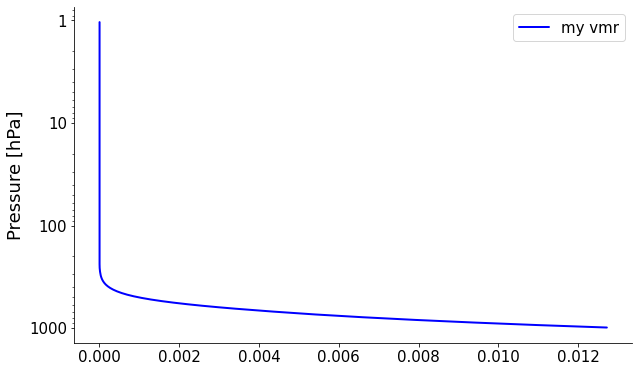

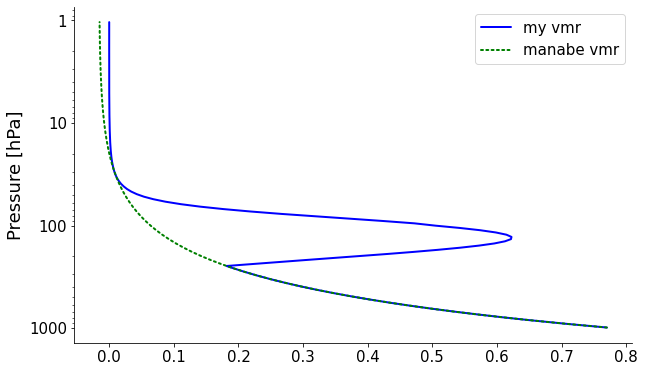

In [8]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

-18.767710263973953
-18.767710263973953
-18.76771026397395
-18.767710263973953
-18.767710263973953
-18.767710263973953
-18.767710263973953
-18.767710263973953
-18.767710263973953
-18.767710263973953
-18.76771026397395
-18.767710263973946
-18.767710263973942
-18.767710263973946
-18.767710263973946
-18.767710263973946
-18.767710263973946
-18.767710263973946
-18.767710263973953
-18.767710263973946
-18.767710263973942
-18.76771026397394
-18.76771026397394
-18.767710263973942
-18.767710263973946
-18.767710263973942
-18.767710263973946
-18.76771026397395
-18.767710263973953
-18.76771026397396
-18.767710263973964
-18.76771026397396
-18.76771026397396
-18.76771026397396
-18.76771026397396
-18.76771026397396
-18.76771026397396
-18.767710263973964
-18.767710263973964
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.767710263973967
-18.76771026

-18.767710263974315
-18.767710263974315
-18.767710263974315
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974326
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.767710263974323
-18.76771026397433
-18.767710263974333
-18.76771026397433
-18.767710263974333
-18.767710263974333
-18.767710263974333
-18.76771026397433
-18.76771026397433
-18.76771026397433
-18.76771026397433
-18.767710263974333
-18.767710263974333
-18.767710263974337
-18.767710263974337
-18.76771026397434
-18.76771026397434
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.76771026397434
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.767710263974344
-18.76771026397435
-18.767710

-18.767710263974635
-18.767710263974642
-18.767710263974642
-18.767710263974642
-18.767710263974642
-18.767710263974646
-18.76771026397465
-18.76771026397465
-18.76771026397465
-18.76771026397465
-18.767710263974653
-18.76771026397465
-18.767710263974653
-18.767710263974656
-18.767710263974653
-18.767710263974656
-18.76771026397466
-18.767710263974656
-18.767710263974656
-18.767710263974656
-18.767710263974656
-18.767710263974656
-18.767710263974664
-18.767710263974667
-18.767710263974667
-18.767710263974667
-18.76771026397467
-18.76771026397467
-18.767710263974678
-18.767710263974678
-18.76771026397468
-18.76771026397468
-18.767710263974685
-18.76771026397468
-18.76771026397468
-18.767710263974685
-18.767710263974692
-18.767710263974692
-18.767710263974692
-18.767710263974692
-18.767710263974696
-18.767710263974696
-18.7677102639747
-18.7677102639747
-18.767710263974703
-18.767710263974703
-18.7677102639747
-18.7677102639747
-18.7677102639747
-18.7677102639747
-18.7677102639747
-18.76

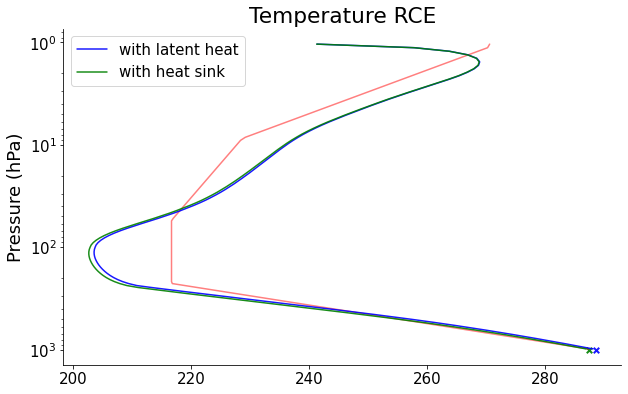

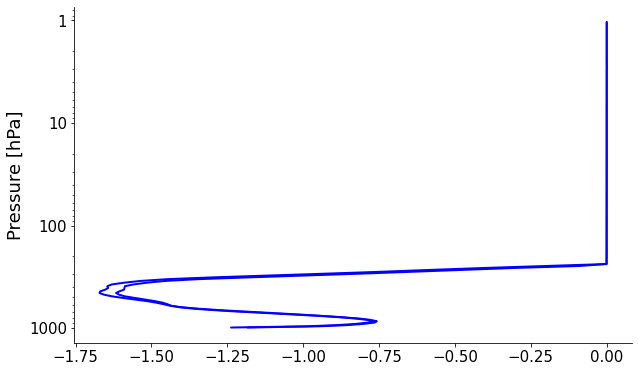

In [27]:
#### PRECIPITATION TEST

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)

prec_eff = 0.5

fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    atm_rad = np.sum(rad_heat_atm)
    
    
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:conv_top] = ((1-prec_eff) * 
                                rad_heat_atm[:conv_top]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[:conv_top] * seconds_day)
    
    heating_rates[conv_top:] = (rad_heat_atm[conv_top:]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[conv_top:] * seconds_day)

    prec_heating = prec_eff * np.sum(rad_heat_atm[:conv_top]) #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv
    
    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    SH = 0.
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    LH = latent_heat(vmr_bl, surface['temperature'],atmosphere['phlev'][0])

    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += heating_rates * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    conv_top = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],conv_top)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
    
    print(M_w)

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with latent heat and precipitation, then with heat sink:')
print('surface T',
      surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_mass * seconds_day)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

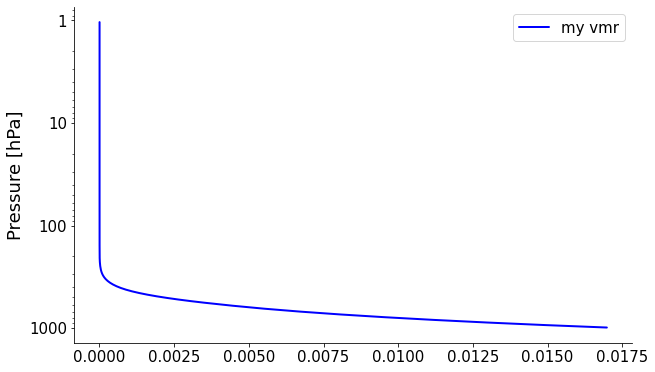

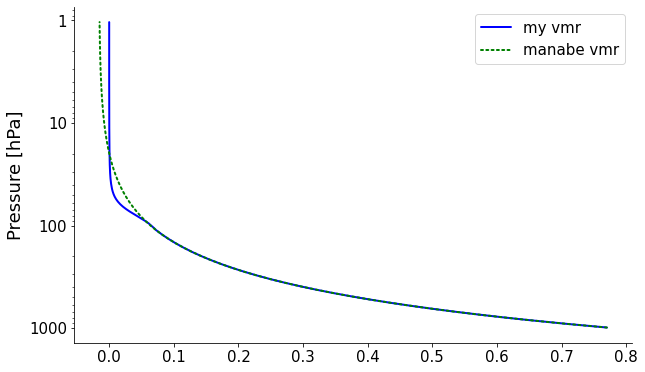

In [12]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

first with latent heat and precipitation, then with heat sink:
surface T [311.12859899] 286.86375349745487
toa radiation [13.1724361] [65.37531571]
surface radiation 215.78183747792855 168.30981184681013
atmosphere radiative cooling [-202.60940138] -202.60940137774503
precipitation heat (J s-1 m-2) and mass (mm day-1) -101.30230495962172 -3.4996078162780155
latent heat evaporation (J s-1 m-2) and mass (mm day-1) [102.66717084] [3.54675872]
Column mass of water vapor (kg m-2) [146.08624912]


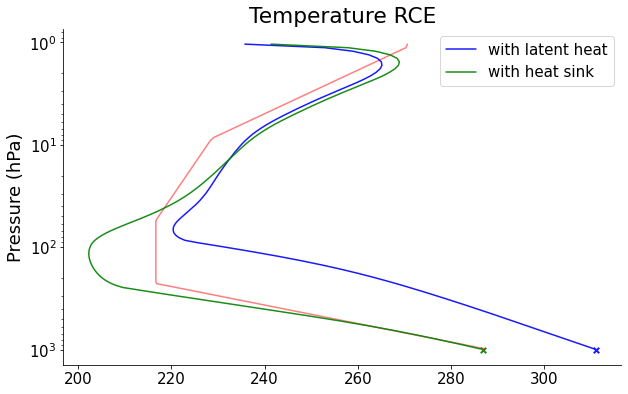

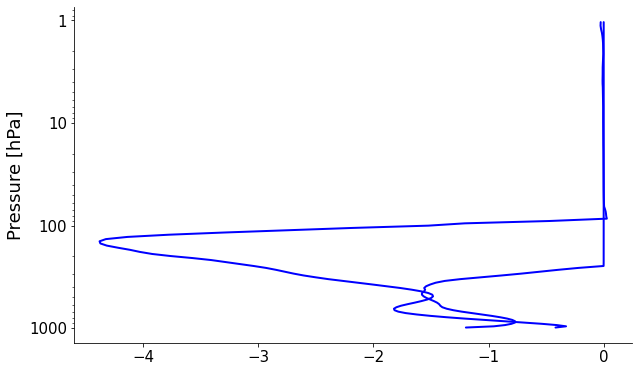

In [32]:
#### PRECIPITATION TEST

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)

ndays = 2000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

prec_eff = 0.5

fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    atm_rad = np.sum(rad_heat_atm)
    
    
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:conv_top] = ((1-prec_eff) * 
                                rad_heat_atm[:conv_top]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[:conv_top] * seconds_day)
    
    heating_rates[conv_top:] = (rad_heat_atm[conv_top:]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[conv_top:] * seconds_day)

    prec_heating = prec_eff * np.sum(rad_heat_atm[:conv_top]) #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv
    
    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    SH = 0.
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    LH = latent_heat(vmr_bl, surface['temperature'],atmosphere['phlev'][0])

    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += heating_rates * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    conv_top = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + (prec_mass + LH/Lv)*seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],conv_top)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
    

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with latent heat and precipitation, then with heat sink:')
print('surface T',
      surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_mass * seconds_day)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)
print('Column mass of water vapor (kg m-2)', M_w)

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

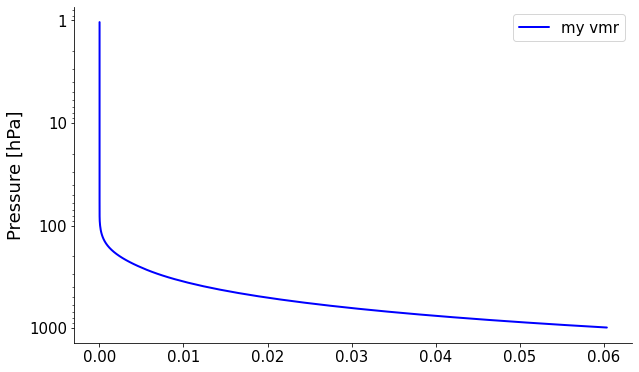

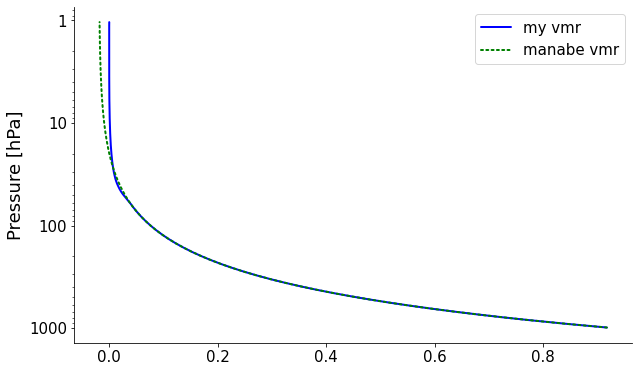

In [34]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

18.767710263973953
[0.34152082]
[0.6738594]
[0.76388155]
[0.80369934]
[0.82525698]
[0.83706655]
[0.84684315]
[0.85113523]
[0.85900942]
[0.86323405]
[0.86359274]
[0.86519937]
[0.86730089]
[0.87265831]
[0.87073764]
[0.87417267]
[0.8730404]
[0.87275649]
[0.87288263]
[0.87524583]
[0.87603605]
[0.87686008]
[0.87757671]
[0.87819957]
[0.87873068]
[0.877538]
[0.87600422]
[0.87495734]
[0.87417627]
[0.873558]
[0.8730228]
[0.87253907]
[0.86990699]
[0.86781088]
[0.8661504]
[0.86473877]
[0.8634792]
[0.86231669]
[0.86121971]
[0.85914532]
[0.85626501]
[0.85393139]
[0.85193795]
[0.85015054]
[0.84849115]
[0.84692086]
[0.84541962]
[0.8431536]
[0.83994508]
[0.83729686]
[0.83498238]
[0.83286836]
[0.8308944]
[0.829006]
[0.82718386]
[0.82542481]
[0.82317108]
[0.81979915]
[0.81697673]
[0.81447838]
[0.81216562]
[0.80998372]
[0.80790973]
[0.80587478]
[0.8039021]
[0.80198525]
[0.80011364]
[0.79716268]
[0.79407313]
[0.79139314]
[0.78895547]
[0.78670886]
[0.78437759]
[0.78222107]
[0.78010163]
[0.77789881]
[0.7759

[0.37255077]
[0.37260751]
[0.37264962]
[0.37269703]
[0.37274618]
[0.37280592]
[0.3728517]
[0.37290576]
[0.37294446]
[0.37300015]
[0.37305749]
[0.37312081]
[0.37316999]
[0.37322159]
[0.37327555]
[0.37333187]
[0.37340176]
[0.37345481]
[0.37351275]
[0.373559]
[0.37362114]
[0.37368962]
[0.37375229]
[0.37381465]
[0.37387421]
[0.37393524]
[0.37399667]
[0.37405226]
[0.37412349]
[0.3742309]
[0.37421725]
[0.374164]
[0.37427852]
[0.37434745]
[0.37441606]
[0.37447447]
[0.37453448]
[0.37465194]
[0.37466016]
[0.37471265]
[0.37477247]
[0.37484729]
[0.37489416]
[0.37494854]
[0.37501817]
[0.37508231]
[0.37514587]
[0.37520146]
[0.37527227]
[0.37533505]
[0.3753963]
[0.37545453]
[0.37552358]
[0.37559205]
[0.37565695]
[0.37572551]
[0.37579158]
[0.37585459]
[0.37591443]
[0.37597456]
[0.3760619]
[0.37612715]
[0.37619422]
[0.37626364]
[0.37632773]
[0.37641097]
[0.37648194]
[0.37654917]
[0.37662787]
[0.37669423]
[0.37677919]
[0.37683863]
[0.37690912]
[0.37699212]
[0.37707603]
[0.37714204]
[0.37720638]
[0.3772

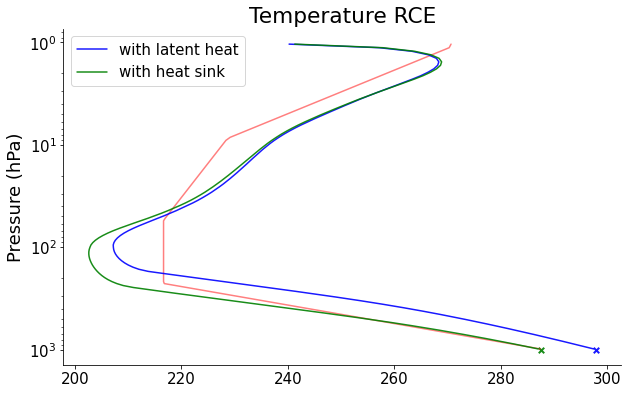

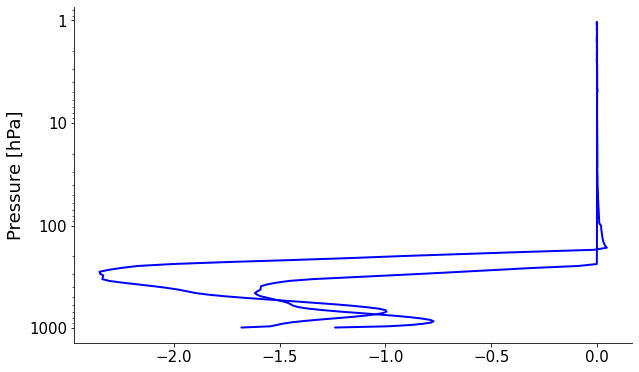

In [12]:
#### PRECIPITATION TEST

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev'])
print(M_w)

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)

Bowen = 0.1
prec_eff = 1/(1+Bowen)

fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    
    rad_heat_atm = np.ones_like(radiation['net_htngrt'][0])
    
    rad_heat_atm[:] = - np.diff(radiation['lw_flxu'][0] + radiation['sw_flxu'][0]-
                             (radiation['lw_flxd'][0] + radiation['sw_flxd'][0]))
    
    atm_rad = np.sum(rad_heat_atm)
    
    
    heating_rates = np.ones_like(rad_heat_atm)
    heating_rates[:conv_top] = ((1-prec_eff) * 
                                rad_heat_atm[:conv_top]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[:conv_top] * seconds_day)
    
    heating_rates[conv_top:] = (rad_heat_atm[conv_top:]/cp_air * 
                                g/-np.diff(atmosphere['phlev'])[conv_top:] * seconds_day)

    prec_heating = prec_eff * np.sum(rad_heat_atm[:conv_top]) #amount of energy invested in precipitation
    prec_mass = prec_heating/Lv
    
    #update net radiaiton at surface

    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    SH = 0.
    
    n_bl = 1
    vmr_bl = np.sum(atmosphere['H2O'][0,:n_bl])/n_bl
    LH = latent_heat(vmr_bl, surface['temperature'],atmosphere['phlev'][0])

    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += heating_rates * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    conv_top = coldpoint(atmosphere['T'][0])
    M_w = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']) + (prec_mass + LH/Lv)*seconds_day*timestep
    
    RH = opt_column_water_to_rh(M_w,atmosphere['T'][0],
                                atmosphere['plev'],atmosphere['phlev'],conv_top)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
    prec_eff = LH/(LH+SH)
    print(prec_eff)

In [ ]:
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=500, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

In [ ]:
print(prec_eff)
print('first with latent heat and precipitation, then with heat sink:')
print('surface T',
      surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',
      radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',
      radiation['toa']-net_rad_surface, atm_rad)
print('precipitation heat (J s-1 m-2) and mass (mm day-1)',
      prec_heating, prec_mass * seconds_day)
print('latent heat evaporation (J s-1 m-2) and mass (mm day-1)', 
      LH, LH/Lv * seconds_day)
print('Column mass of water vapor (kg m-2)', M_w)

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

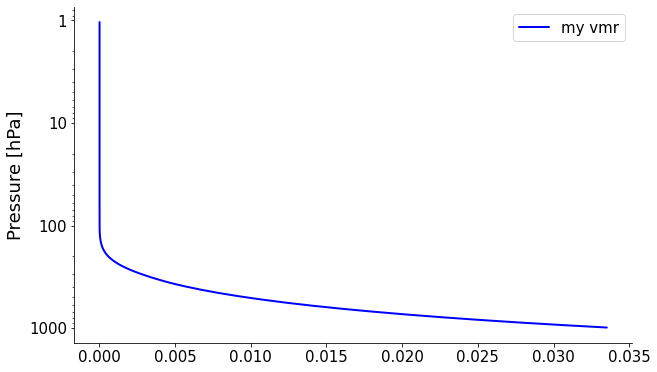

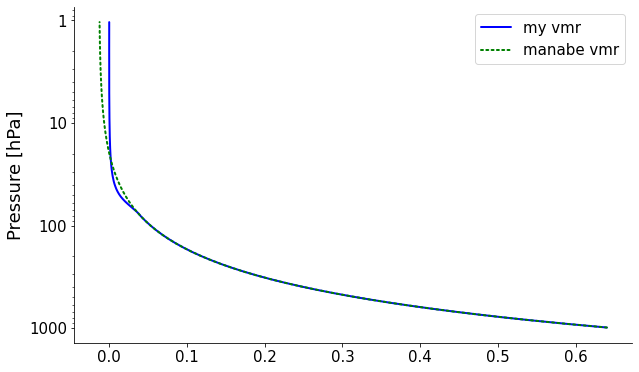

In [9]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

43
56
